In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Subset, Dataset

from torchvision import datasets, transforms, models
from torchvision.transforms import functional as F

from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from matplotlib import pyplot as plt

import os
import sys

In [7]:
# Загружаем CIFAR-10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
data_len = train_dataset.__len__()

In [9]:
# Глобальные параметры
INITIAL_TRAIN_SIZE = int(data_len * 0.01)   # N начальных данных
BATCH_ADD_SIZE = 500                        # K данных для добавления
WARMUP_EPOCHS = 20
TOTAL_TRAIN_SIZE = data_len                    # Общее количество тренировочных данных
NUM_CLASSES = 10                            # CIFAR-10

In [19]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from base_trainer import Trainer
from model import SimpleCNN
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), 'EGL')))

In [ ]:
class EGLTrainer(Trainer):
    def __init__(self, model, optimizer, criterion, train_loader, val_loader, device, scheduler=None, pool_loader=None):
        """
        Инициализация EGLTrainer.
        :param model: Модель для обучения.
        :param optimizer: Оптимизатор.
        :param criterion: Функция потерь.
        :param train_loader: DataLoader для обучающей выборки.
        :param val_loader: DataLoader для валидационной выборки.
        :param device: Устройство ('cuda' или 'cpu').
        :param scheduler: Планировщик обучения (необязательно).
        :param pool_loader: DataLoader для пула неразмеченных данных.
        """
        super().__init__(model, optimizer, criterion, train_loader, val_loader, device, scheduler)
        self.pool_loader = pool_loader

    def select_samples(self, num_samples):

        self.model.eval()
        self.pool_loader
        
        num_classes = len(self.train_loader.dataset.classes)

        gradient_lengths = []
        ###
        ### Этот комментарий в память о тройном цикле for от чата gpt >_<
        ###
        for inputs, _ in tqdm(self.pool_loader, desc="Thingy"):
            inputs = inputs.to(self.device)
            

            # Получаем выходы модели
            outputs = self.model(inputs)  # Tensor [batch_size, num_classes]
            probabilities = torch.softmax(outputs, dim=1)  # Tensor [batch_size, num_classes]

            # Создаем вектор one-hot меток для всех классов
            one_hot_labels = torch.eye(outputs.size(1), device=self.device)  # Tensor [num_classes, num_classes]

            # Расширяем one-hot метки для батча
            expanded_labels = one_hot_labels.unsqueeze(0).repeat(outputs.size(0), 1, 1)  # [batch_size, num_classes, num_classes]

            # Расширяем выходы модели для вычитания
            expanded_outputs = outputs.unsqueeze(1).repeat(1, outputs.size(1), 1)  # [batch_size, num_classes, num_classes]

            # Вычисляем потери для всех пар (объект, метка) в батче
            losses = self.criterion(expanded_outputs.view(-1, outputs.size(1)), expanded_labels.view(-1, outputs.size(1)))  # [batch_size * num_classes]

            # Считаем градиенты для всех потерь
            grads = torch.autograd.grad(
                losses.sum(),
                self.model.parameters(),
                retain_graph=True,
                create_graph=False
            )

            # Вычисляем длины градиентов
            grad_square_norms = torch.norm(torch.cat([g.view(-1) for g in grads])) # torch.cat([g.flatten(1).pow(2).sum(1) for g in grads]).sum(dim=0)  # [batch_size, num_classes]

            # Мат ожидание
            batch_gradient_expectations = (probabilities * grad_square_norms).sum(dim=1)  # [batch_size]

            gradient_lengths.extend(batch_gradient_expectations.cpu().detach().numpy())

        # Выбираем `num_samples` с максимальной длиной градиента
        informative_indices = torch.topk(torch.tensor(gradient_lengths), num_samples).indices
        return informative_indices
    
    def fit(self, num_epochs):

        """
        Полный цикл обучения.
        :param num_epochs: Количество эпох
        """
        for epoch in range(num_epochs):
            print(self.select_samples(5))
            train_loss = self.train_step()
            val_loss, accuracy, f1 = self.val_step()

            if self.scheduler is not None:
                if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

            
            # print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {accuracy:.4f}, F1: {f1:.4f}")




In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [20]:
model = SimpleCNN(10)

In [21]:
EPOCHS = 1
learning_rate = 5e-4
total_steps = len(train_dataloader) * EPOCHS

optimizer = optim.AdamW(model.parameters(), lr=learning_rate )
# from adabelief_pytorch import AdaBelief
# optimizer = AdaBelief(model.parameters(), lr=learning_rate, eps=learning_rate, betas=(0.9, 0.999), weight_decay=1e-2, weight_decouple=False, rectify=True, print_change_log = False)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate , total_steps=total_steps, pct_start=0.1, anneal_strategy='linear')


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE


'cuda'

In [58]:
trainer = EGLTrainer(model=model.to(DEVICE), 
                     optimizer=optimizer,
                     criterion=criterion, 
                     train_loader=train_dataloader, 
                     val_loader=val_dataloader, 
                     device=DEVICE, 
                     scheduler = scheduler, 
                     pool_loader=train_dataloader)

In [59]:
trainer.fit(EPOCHS)


Thingy: 100%|██████████| 782/782 [00:11<00:00, 67.17it/s]


tensor([33698, 33699, 33690, 33681, 33682])


Validating: 100%|██████████| 157/157 [00:02<00:00, 75.09it/s]

Validation Loss: 0.7976, Accuracy: 0.7247, F1 Score: 0.7219


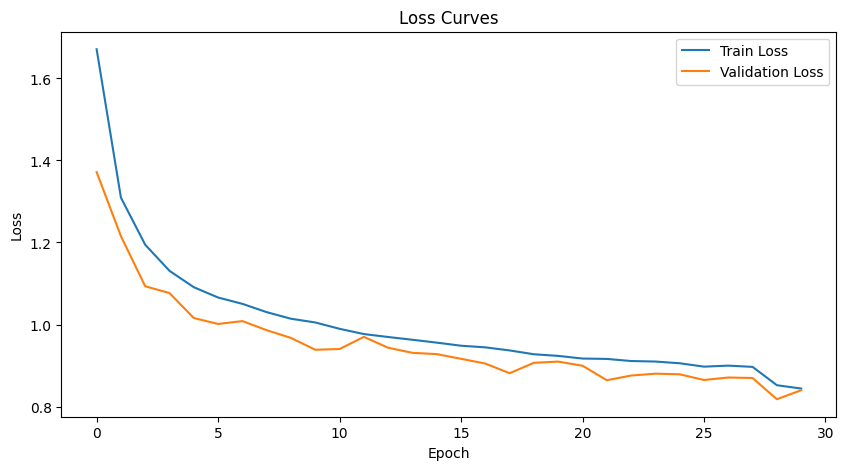

In [37]:
trainer.plot_losses()

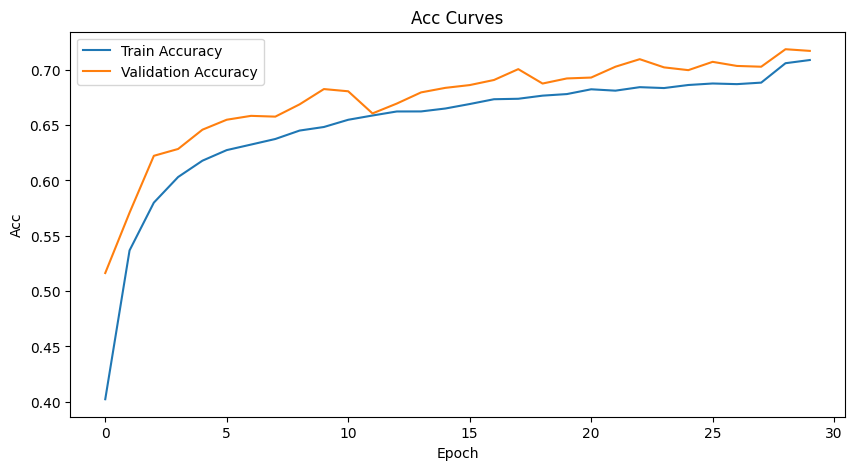

In [38]:
trainer.plot_acc()

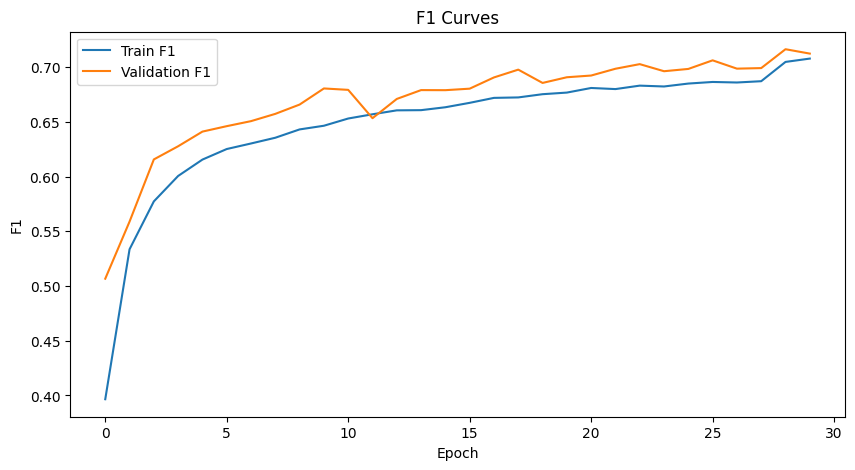

In [39]:
trainer.plot_f1()

In [10]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))


In [11]:
from base_trainer import Trainer

In [12]:
trainer = Trainer(model=model.to(DEVICE), optimizer=optimizer,criterion=criterion, train_loader=train_dataloader, val_loader=val_dataloader, device=DEVICE, scheduler = scheduler)

In [13]:
trainer.fit(5)

Validating: 100%|██████████| 157/157 [00:02<00:00, 77.56it/s]


Validation Loss: 1.1971, Accuracy: 0.5813, F1 Score: 0.5716
Epoch 1/5 - Train Loss: 1.4456, Val Loss: 1.1971, Acc: 0.5813, F1: 0.5716


Validating: 100%|██████████| 157/157 [00:02<00:00, 78.22it/s]


Validation Loss: 1.0325, Accuracy: 0.6368, F1 Score: 0.6324
Epoch 2/5 - Train Loss: 1.1362, Val Loss: 1.0325, Acc: 0.6368, F1: 0.6324


Validating: 100%|██████████| 157/157 [00:02<00:00, 77.56it/s]


Validation Loss: 0.9409, Accuracy: 0.6731, F1 Score: 0.6702
Epoch 3/5 - Train Loss: 1.0026, Val Loss: 0.9409, Acc: 0.6731, F1: 0.6702


Validating: 100%|██████████| 157/157 [00:02<00:00, 76.66it/s]


Validation Loss: 0.8854, Accuracy: 0.6921, F1 Score: 0.6893
Epoch 4/5 - Train Loss: 0.9173, Val Loss: 0.8854, Acc: 0.6921, F1: 0.6893


Validating: 100%|██████████| 157/157 [00:02<00:00, 76.14it/s]


Validation Loss: 0.8437, Accuracy: 0.7077, F1 Score: 0.7050
Epoch 5/5 - Train Loss: 0.8472, Val Loss: 0.8437, Acc: 0.7077, F1: 0.7050


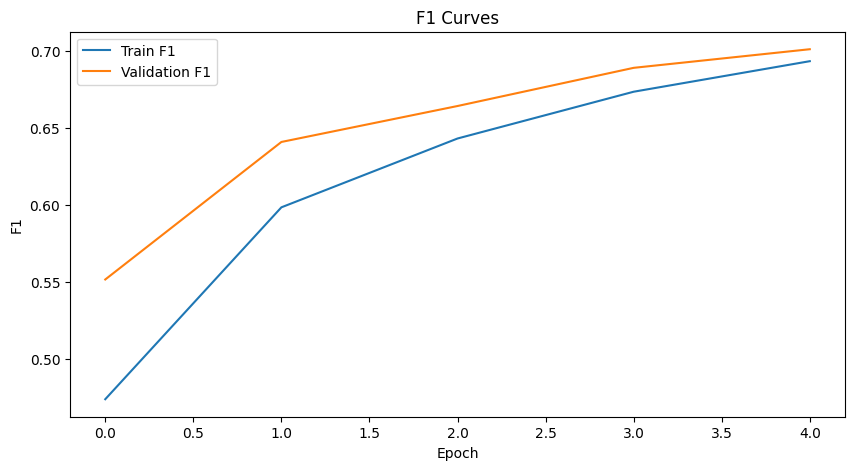

In [18]:
trainer.plot_f1()